# ADMM

This document is devoted to the resolution of discrete mean field games via Augmented Lagrangian methods (see  {cite}`benamou2000computational` for an example in fluid mechanics).

## Packages

In [41]:
import numpy as np
from numpy import random

from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.animation as animation

import time

## Potential formulation and dual minimization

We define a dual criterion

$$\mathcal{D}(P,u,\gamma) := \langle m_0(\cdot), u(0,\cdot)\rangle_{u}  +\sum_{t\in \mathcal{T}} - F^\star[\gamma](t) \Delta_t\Delta_x- \phi^\star[P](t)\Delta_t -  F^\star[\gamma](T)\Delta_x $$

and a dual problem


$$\begin{array}{c}
 \displaystyle \sup_{\begin{subarray}{c}
 (P,u) \in \mathcal{K}, \; \gamma\in \mathbb{R}(\bar{\mathcal{T}} \times S), \\
 (a,b) \in \mathcal{Q}
\end{subarray}}  \mathcal{D}(P,u,\gamma) \\
 \text{s.t.}  \begin{cases}
u(t,x)/\Delta_t - \gamma(t,x) = a(t,x) & (t,x) \in \mathcal{T} \times S,\\
-\alpha(t,x,y)P(t) -u(t+1,y)/\Delta_t = b(t,x,y)  & (t,x,y) \in \mathcal{T} \times S \times S,\\
u(T,x)-\gamma(T,x) = 0  & x \in  S,\\
\end{cases}
\end{array}$$

where

$$\mathcal{K} =  \mathbb{R}(\mathcal{T}) \times \mathbb{R}(\bar{\mathcal{T}} \times S), \qquad \mathcal{Q} :=  \left\{ (a,b) \in \mathbb{R}(\mathcal{T} \times S) \times  \mathbb{R}(\mathcal{T} \times S \times S) , \quad \ell^\star[b](t,x) + a(t,x) \leq 0 \right\}.$$

Then we define the __Lagrangian__ associated to the above problem:

$$\mathcal{L}(P,u,\gamma,a,b,m,w) =  \mathcal{D}(P,u,\gamma) - \chi_{\mathcal{Q}}(a,b) - \langle m, (I_0/\Delta_t + I/\Delta_t + I_T)u - \gamma - \bar{a} \rangle_{m} - \langle w,-A^\star[P] -S^\star[u]/\Delta_t - b\rangle_{w}.$$

We define the __Augmented Lagrangian__ parametrized by $r>0$ as follows


$$\mathcal{L}_r(P,u,\gamma,a,b,m,w) = \mathcal{L}(P,u,\gamma,a,b,m,w) - \frac{r}{2}\| ((I_0/\Delta_t + I/\Delta_t + I_T)u - \gamma -\bar{a},-A^\star[P] -S^\star[u]/\Delta_t - b) \|^2_{m,w}.$$

##  Algorithm

The Algorithm is given by :

$(P^0,u^0,\gamma^0,a^0,b^0,m^0,w^0) \leftarrow (P,u,\gamma,a,b,m,w)$

For $0\leq n < N$ 

* Find 

$$P^{n+1} \in argmax_{P \in \mathbb{R}(\mathcal{T})} \mathcal{L}_r(P,u^n,\gamma^n,a^n,b^n,m^n,w^n)$$
* Find 

$$u^{n+1} \in argmax_{u \in \mathbb{R}(\bar{\mathcal{T}} \times S)} \mathcal{L}_r(P^{n+1},u,\gamma^n,a^n,b^n,m^n,w^n)$$

* Find 

$$\gamma^{n+1} \in argmax_{\gamma \in \mathbb{R}(\bar{\mathcal{T}} \times S)} \mathcal{L}_r(P^{n+1},u^{n+1},\gamma,a^n,b^n,m^n,w^n)$$

* Find 

$$(a^{n+1},b^{n+1}) \in argmax_{(a,b) \in \mathcal{Q}} \mathcal{L}_r(P^{n+1},u^{n+1},\gamma^{n+1},a,b,m^n,w^n)$$

* Actualise $(m,w)$ via a gradient descent step 

$$(m^{n+1},w^{n+1}) = (m^{n},w^{n}) + q((I_0/\Delta_t + I/\Delta_t + I_T)u^{n+1}-\gamma^{n+1}-\bar{a}^{n+1}, - A^\star[P^{n+1}] - S^\star[u^{n+1}]/\Delta_t - b^{n+1})$$

End for

* Return $(P^N,u^N,\gamma^N,a^N,b^N,m^N,w^N)$.

## Data of the problem

In [42]:
def initial_mass(n):
    m_bar = np.zeros(n)
    for x in range(n):
        m_bar[x] = np.exp(-(x-n/2)**2/(n/4)**2)
    return(n*m_bar/np.sum(m_bar))


def displacement_cost(T,n):
    dx=1/n
    dt=1/T
    disp = np.zeros((T-1,n,n))
    for t in range(T-1):
        for x in range(n):
            for y in range(n):
                disp[t,x,y] = ((y-x)*dx/dt)**2/4
    return(disp)

def penalisation_congestion(T,n):
    nu = np.zeros((T,n)) 
    for t in range(T):
        if t > T/2 and t < 3*T/4:
            for x in range(n):
                if x > n/2:
                    nu[t,x] = 10
    return(nu)

def sharp_penalisation_congestion(T,n):
    eta = np.zeros((T,n)) + 3
    for t in range(T):
        for x in range(n):
            if (t > T/3 and t < 2*T/3) and (x > n/3 and x < 2*n/3):
                    eta[t,x] = 1/4
    return(eta)

def reference_demand(T):
    new_Db = np.zeros(T-1)
    for t in range(T-1):
        new_Db[t] = np.sin(t*(4*np.pi)/(T-1))
    return(new_Db)

def alpha_cost(T,n):
    dx=1/n
    dt=1/T
    disp = np.zeros((T-1,n,n))
    for t in range(T-1):
        for x in range(n):
            for y in range(n):
                disp[t,x,y] = (y-x)*dx/dt
    return(disp)

def alpha_bar(alpha,T,n):
    new_alpha = np.zeros((T-1,n))
    a = np.zeros(T-1)
    for t in range(T-1):
        for x in range(n):
            new_alpha[t,x] = np.sum(alpha[t,x]**2)
        a[t] = np.sum(new_alpha[t])
    return(a)

## Computation of ADMM steps

### Computation of $P^{n+1}$

__Proximal formulation__

$$
\begin{array}{rl}P^{n+1}& = \text{arg min}_{P \in \mathbb{R}(\mathcal{T})} \;  \frac{r}{2} \| A^\star[P] + S^\star[u^n]/\Delta_t + b^n \|_{w}^2  + \phi^\star(P) \Delta_t - \langle w^n,A^\star[P] \rangle_{w} 
\\
& = \text{arg min}_{P \in \mathbb{R}(\mathcal{T})} \; \frac{r}{2} \| A^\star[P] + S^\star[u^n]/\Delta_t + b^n \|^2  + \phi^\star(P)/ \Delta_x - \langle w^n,A^\star[P] \rangle \\
& = \text{arg min}_{P \in \mathbb{R}(\mathcal{T})} \;  \frac{1}{2} \|P\|^2 + \langle P, A[S^\star[u^n]/\Delta_t + b^n - w^n/r]/\bar{\alpha}\rangle  + \phi^\star(P)/(r\bar{\alpha} \Delta_x)  \\
& = \text{arg min}_{P \in \mathbb{R}(\mathcal{T})} \;  \frac{1}{2}\| P + A[ (- w^n/r + S^\star[u^n]/\Delta_t + b^n)]/\bar{\alpha} \|^2  + \phi^\star(P)/(r\bar{\alpha} \Delta_x) \end{array}$$

where the division has to be understood as a Hadamard product and

$$\bar{\alpha}(t) := \sum_{(x,y) \in S \times S} \alpha(t,x,y)^2.$$

Then $P^{n+1}$ is given by

$$P^{n+1} = \text{prox}_{\phi^\star/(r\bar{\alpha} \Delta_x)} \left(A[( w^n/r - S^\star[u^n]/\Delta_t - b^n)]/\bar{\alpha}\right).$$

__Computation via Moreau's identity__:

Due to the above definition of $\phi^\star$ and the Moreau identity, we have that

$$ \text{prox}_{\lambda \phi^\star}(x) = x - \lambda\text{prox}_{\lambda^{-1} \phi}(\lambda^{-1}x),$$

for any $\lambda>0$. In addtion for any $\xi>0$ we have that

$$\begin{equation}
\text{prox}_{\xi \phi}(x) = \begin{cases} D_{max} & \text{ if }  \frac{x - \tau D_0 \bar{D}}{1 + \tau D_0} > D_{max} \\
 D_{min} & \text{ if }  \frac{x - \tau D_0 \bar{D}}{1 + \tau D_0} < D_{min} \\
 \frac{x - \tau D_0 \bar{D}}{1 + \tau D_0} & \text{otherwise}
\end{cases} \end{equation}$$

In [43]:
def prox_phi_quad(X,Db,D_0,tau,D_min,D_max):
    argmin = (X - tau*D_0*Db)/(1 + tau*D_0)
    if argmin > D_max:
        argmin = D_max
    if argmin < D_min:
        argmin = D_min
    return(argmin)

def Local_P_prox_quad(u,b,w,n,r,alpha,var_alpha,Db,D_0,D_min,D_max,t):
    dt=1/T
    dx=1/n
    Z = np.zeros((n,n))
    for x in range(n):
        Z[x] = (w[t,x]/r - u[t+1]/dt - b[t,x])*alpha[t,x]
    X = np.sum(Z)/var_alpha[t]
    lambde = 1/(r*var_alpha[t]*dx)
    new_Pt = X - lambde*prox_phi_quad(X/lambde,Db[t],D_0,1/lambde,D_min,D_max)
    return(new_Pt)

def P_argmin_L(u,b,w,T,n,r,alpha,var_alpha,Db,D_0,D_min,D_max):
    new_P = np.zeros(T-1)
    for t in range(T-1):
        new_P[t] = Local_P_prox_quad(u,b,w,n,r,alpha,var_alpha,Db,D_0,D_min,D_max,t)
    return new_P

### Computation of $u^{n+1}$

$u^{n+1}$ is given by

$$ \begin{align} u^{n+1}    =  \text{arg min}_{u \in \mathbb{R}(\bar{\mathcal{T}}\times S)}  \langle m^n-\bar{m}_0, (I_0/\Delta_t + I/\Delta_t + I_T)u \rangle_{m} - \langle w^n, S^\star u/\Delta_t \rangle_{w} + \frac{r}{2} \left( \|(I_0/\Delta_t + I/\Delta_t + I_T) u - \gamma^n - \bar{a}^n \|_{m}^2 + \|S^\star u /\Delta_t + A^\star P^{n+1} + b^n \|_{w}^2 \right) \\[2em]
=  \text{arg min}_{u \in \mathbb{R}(\bar{\mathcal{T}}\times S)}  \langle (I_0\Delta_t + I + I_T) ((m^n-\bar{m}_0)/r - \gamma^n - \bar{a}^n) - S w^n/r + S[A^\star P^{n+1} + b^n], u \rangle_{u} + \frac{1}{2}( \langle (I_0 + I/\Delta_t + I_T) u, u \rangle_{u} +
\langle u, S S^\star  u /\Delta_t \rangle_u \end{align}
$$

with

$$ S S^\star u (t,x) = \begin{cases}  0 & t=0, \\ u(t,x) n & t>0. \end{cases}$$


Then

$$u^{n+1}(t) = \begin{cases} ((m^n-\bar{m}_0)/r + \gamma^n + a^n)(t) \Delta_t  & t=0, \\
\left( (Sw^n-m^n)/r + \gamma^n + a^n - S[A^\star P^n + b^n] \right)(t)\Delta_t  /(1+n) & 0<t<T, \\
\left( (Sw^n-m^n)/r + \gamma^n - S[A^\star P^n + b^n]\right)(t)/(1 +n/\Delta_t)  & t = T, \end{cases}$$

for any $t \in \bar{\mathcal{T}}$.

In [44]:
def u_argmin_L(P,gamma,a,b,m,w,m_0,alpha,T,n,r):
    dt=1/T
    new_u = np.zeros((T,n))
    for t in range(T):
        for x in range(n):
            if t==0:
                new_u[t,x] = ((m_0[x] - m[t,x])/r + gamma[t,x] + a[t,x])*dt
            elif t==(T-1):
                new_u[t,x] = ((-m[t,x] + np.sum(w[t-1,:,x]))/r + gamma[t,x] - np.sum(alpha[t-1,:,x]*P[t-1] + b[t-1,:,x]))/(1+n/dt)
            else:  
                new_u[t,x] = ((-m[t,x] + np.sum(w[t-1,:,x]))/r + gamma[t,x] + a[t,x] - np.sum(alpha[t-1,:,x]*P[t-1] + b[t-1,:,x]))*dt/(1+n)
    return new_u

### Computation of $\gamma^{n+1}$

__Proximal formulation__

$\gamma^{n+1}$ is given by

$$ 
\gamma^{n+1} = \text{arg min}_{\gamma \in \mathbb{R}(\bar{\mathcal{T}} \times S)}  \frac{1}{2} \|m^n/r + (I_0/\Delta_t + I/\Delta_t + I_T)u^{n+1} -  \bar{a}^n - \gamma \|_{m}^2 + \sum_{t \in \mathcal{T}} F^\star[\gamma](t)\Delta_x\Delta_t/r + F^\star[\gamma](T)\Delta_x/r.
$$

$$\gamma^{n+1}(t) = \begin{cases}
\text{prox}_{F^\star/r}\left(m^n/r + u^{n+1}/\Delta_t - \bar{a}^n\right)(t) & t<T, \\
\text{prox}_{F^\star/r}\left(m^n/r + u^{n+1}\right)(t) & t = T. \end{cases}$$

for any $t \in \bar{\mathcal{T}}$.

__Computation via Moreau's identity__:

Due to the above definition of $F^\star$ and the Moreau identity, we have that

$$ \text{prox}_{\lambda F^\star}(x) = x - \lambda\text{prox}_{\lambda^{-1} F}(\lambda^{-1}x),$$

for any $\lambda>0$. In addtion for any $\xi>0$ we have that

$$\text{prox}_{\xi F}(x) = \begin{cases} \eta & \text{ if } (x- \xi \nu)/(1+ \xi) > \eta \\
0 & \text{ if } (x- \xi \nu)/(1+ \xi)<0 \\
(x- \xi \nu)/(1+ \xi) &\text{ otherwise } \end{cases}.$$

In [45]:
def prox_coeff_F_sharp(X,nu,eta,coeff):
    argmin = (X - coeff*nu)/(coeff + 1)
    if argmin>eta:
        argmin = eta
    if argmin<0:
        argmin = 0
    return(argmin)

        
def Moreau_id_F(X,nu,eta,lambde):
    return(X-lambde*prox_coeff_F_sharp(X/lambde,nu,eta,1/lambde))


def Moreau_gamma_argmin_L(u,a,m,nu,eta,T,n,r):
    dt = 1/T
    new_gamma = np.zeros((T,n))
    for t in range(T):
        for x in range(n):
            if t == T-1:
                X = m[t,x]/r + u[t,x]
                new_gamma[t,x] = Moreau_id_F(X,nu[t,x],eta[t,x],1/r)
            else:
                X = m[t,x]/r + u[t,x]/dt - a[t,x]
                new_gamma[t,x] = Moreau_id_F(X,nu[t,x],eta[t,x],1/r)
    return(new_gamma)

### Computation of $(a^{n+1},b^{n+1})$

$$(a^{n+1},b^{n+1})  = \Pi_{\mathcal{Q}} \big(m^n/r + u^{n+1}/\Delta_t - \gamma^{n+1}, w^n/r - A^\star P^{n+1} - S^\star u^{n+1}/\Delta_t \big).$$

In the linear case, the running cost is given by 

$$\ell(t,x,\rho) = \sum_{y\in S} \rho(t,x,y) \beta(t,x,y)$$

with dom$(\ell(t,x,\rho)) = \Delta(S)$. Thus the set $\mathcal{Q}$ is given by

$$\mathcal{Q} :=  \left\{ (a,b) \in \mathbb{R}(\mathcal{T} \times S) \times  \mathbb{R}(\mathcal{T} \times S \times S) , \; b(t,x,y) - \beta(t,x,y) + a(t,x) \leq 0, \text{ for all } (t,x,y) \in \mathcal{T} \times S \times S \right\}.$$

We define

$$ \bar{a}[m,u,\gamma](t,x) = (m/r + u/\Delta_t - \gamma)(t,x), \qquad \bar{b}[w,P,u](t,x,y) = (w^n/r - A^\star P^{n+1} - S^\star u^{n+1}/\Delta_t)(t,x,y).$$

Then for any $(t,x) \in \mathcal{T} \times S$, we aim at finding

$$(a^{n+1}(t,x),b^{n+1}(t,x,\cdot))  = \Pi_{Q} \big(\bar{a}[m^n,u^{n+1},\gamma^{n+1}](t,x), \bar{b}[w^n,P^{n+1},u^{n+1}](t,x,\cdot) \big)$$

where

$$Q(t,x) := \left\{ (a,b) \in \mathbb{R} \times  \mathbb{R}(S) , \; b(y) - \beta(t,x,y) + a \leq 0, \text{ for all } y \in S \right\}.$$

To compute this projection, we define the following __minimisation problem__

$$\min_{a} \min_{\begin{subarray}{c} b \\ b(y) \leq \beta(y) - a,\text{ for all } y\in S \end{subarray}} (a-\bar{a})^{2}/2 + \sum_{y\in S} (b(y)-\bar{b}(y))^2/2$$

The solution to the __subproblem__

$$\min_{\begin{subarray}{c} b \\ b(y) \leq \beta(y) - a,\text{ for all } y\in S \end{subarray}} (a-\bar{a})^{2}/2 + \sum_{y\in S} (b(y)-\bar{b}(y))^2/2$$

is given by

$$b(y) = \min (\bar{b}(y),\beta(y) - a), \quad \text{for all } y \in S.$$

Thus replacing in the __initial problem__ we now need to solve the following optimization problem

$$\min_{a} g(a), \quad g(a) := (a-\bar{a})^{2}/2 + \sum_{y\in S} \max(0,a-\tilde{\beta}(y))^2/2.$$

Let $\tilde{\beta}(y) := \beta(y)-\bar{b}(y)$. We denote $(y_k)_{k\in \{0,\ldots,n-1\}}$ the sequence such that

$$\tilde{\beta}(y_0) \leq \cdots \leq \tilde{\beta}(y_{n-1}).$$

Then the optimal $a$ is such that

```{admonition} Optimal a
$$ a = \left(\bar{a} + \sum_{i = 0}^{k-1} \tilde{\beta}(y_i)\right)/(k+1) $$
```

We have that

$$\partial g(\tilde{\beta}(y_{k})) = (k+1) \tilde{\beta}(y_{k}) - \left(\bar{a} + \sum_{i = 0}^{k-1} \tilde{\beta}(y_i) \right).$$


Then we define the index $k \in \{1,\ldots,n-1 \}$ if the following conditions are satisfied

$$\begin{equation} 
 \partial g (\tilde{\beta}(y_{k-1})) < 0, \qquad  \partial g (\tilde{\beta}(y_{k})) \geq 0.
\end{equation}$$

Otherwise we set $k = n$ if $ \partial g (\tilde{\beta}(y_{n-1})) \leq 0$ and $k = 0$ if $ \partial g (\tilde{\beta}(y_{0})) \geq 0$.

We finally deduce that

```{admonition} Optimal b
$$b(y) = \min \left(\bar{b}(y),\beta(y) - \left(\bar{a} + \sum_{i = 0}^{k-1}\tilde{\beta}(y_i)\right)/(k+1) \right)$$
```

In [46]:
def proj_Q(a_bar,b_bar,beta,n):
    a = 0
    b = np.zeros(n)
    beta_bar = beta-b_bar
    beta_bar_sort = np.sort(beta_bar)
    k = 0
    sum_beta_bar_sort = 0
    derivative_beta = (k+1)*beta_bar_sort[k] - a_bar - sum_beta_bar_sort
    while (derivative_beta < 0) and (k < n-1):
        sum_beta_bar_sort = sum_beta_bar_sort + beta_bar_sort[k]
        k = k+1
        derivative_beta = (k+1)*beta_bar_sort[k] - a_bar - sum_beta_bar_sort
    if (k==n-1) and (derivative_beta < 0):
        sum_beta_bar_sort = sum_beta_bar_sort + beta_bar_sort[k]
        k = n
    a = (a_bar + sum_beta_bar_sort)/(k+1)
    for y in range(n):
        b[y] = np.min(np.array([b_bar[y],beta[y] - a]))
    return (a,b)

def a_b_proj(P,gamma,u,m,w,T,n,r,alpha,beta):
    dt=1/T
    (new_a,new_b) = (np.zeros((T-1,n)),np.zeros((T-1,n,n)))
    for t in range(T-1):
        for x in range(n):
            c_1 = m[t,x]/r + u[t,x]/dt - gamma[t,x]
            c_3 = w[t,x]/r - alpha[t,x]*P[t] - u[t+1]/dt
            (new_a[t,x],new_b[t,x]) = proj_Q(c_1,c_3,beta[t,x],n)
    return(new_a,new_b)

#print(proj_Q(np.array([2]),np.array([2,2,-2,5,3]),np.array([0,1,2,3,3]),5))

### Computation of $(m^{n+1},w^{n+1})$

We recall that the actualisation of $(m^{n+1},w^{n+1})$ is given by a gradient descent step 

$$(m^{n+1},w^{n+1}) = (m^{n},w^{n}) + q((I_0/\Delta_t + I/\Delta_t + I_T)u^{n+1} - \gamma^{n+1} -\bar{a}^{n+1},-A^\star P^{n+1} -S^\star u^{n+1}/\Delta_t - b^{n+1})$$

In [47]:
def m_w_gradient_step(P,gamma,u,a,b,m,w,q,T,n):
    dt=1/T
    new_m = np.zeros((T,n))
    new_w = np.zeros((T-1,n,n))
    for t in range(T-1):
        for x in range(n):
            new_m[t,x] = m[t,x] + q*(u[t,x]/dt - gamma[t,x] - a[t,x])
            new_w[t,x] = w[t,x] + q*(- alpha[t,x]*P[t] - u[t+1]/dt - b[t,x])
    new_m[T-1] = m[T-1] + q*(u[T-1] - gamma[T-1])
    return (new_m,new_w)

__Strategy__ $\pi = w/m$ __and average strategy__

In [48]:
def equilibrium_strategy(m,w,T,n,tol=1e-5):
    strat = np.zeros((T-1,n,n))
    for t in range(T-1):
        for x in range(n):
            if m[t,x] > tol:
                strat[t,x] = w[t,x]/m[t,x]
    return(strat)

def mean_field_strategy(pi,T,n):
    mfs = np.zeros((T-1,n))
    for t in range(T-1):
        for x in range(n):
            for y in range(n):
                mfs[t,x] += pi[t,x,y]*(y-x)
    return(mfs)

__Reconstruction of__ $(u,\pi[u])$

In [49]:
def d_p_mapping(m,w,gamma,P,alpha,beta,T,n,tol = 1e-3,mfg=1):
    dt=1/T
    dx=1/n
    new_u = np.zeros((T,n))
    new_pi = np.zeros((T-1,n,n))
    f = np.zeros((T,n))
    if mfg == 1:
        f = gamma
    new_u[T-1] = f[T-1]
    for t in range(T-1):
        for x in range(n):
            cost = np.zeros(n)
            cost = beta[T-2-t,x]*dt + alpha[T-2-t,x]*P[T-2-t]*dt + new_u[T-1-t]
            argmin = np.argmin(cost)
            if m[T-2-t,x]*dx>tol: 
                new_pi[T-2-t,x] = w[T-2-t,x]/m[T-2-t,x]
            else:
                new_pi[T-2-t,x,argmin] = 1
            new_u[T-2-t,x] = cost[argmin] + f[T-2-t,x]*dt
    return(new_u,new_pi)

### Errors

In [50]:
def verification(P,u,gamma,m,pi,w,T,n,beta,nu,m_0,alpha,Db,Dmin,Dmax,eta,mfg = 1):
    cost = np.zeros((T-1,n))
    Delta_u = np.zeros((T,n))
    Delta_pi = np.zeros((T-1,n,n))
    Delta_m = np.zeros((T,n))
    Delta_gamma = np.zeros((T,n))
    Delta_P = np.zeros(T-1)
    demand = np.zeros((T-1,n,n))
    dt=1/T
    dx=1/n
    f = np.zeros((T,n))
    if mfg == 1:
        f = gamma
    Delta_m[0] = abs(m[0] - m_0)*dx
    for x in range(n):
        Delta_u[T-1,x] = abs(u[T-1,x] - f[T-1,x])*dx
    for t in range(T-1):
        for x in range(n):
            arg = beta[t,x]*dt + alpha[t,x]*P[t]*dt + u[t+1]
            demand[t,x] = pi[t,x]*m[t,x]*alpha[t,x]*dx
            cost[t,x] = np.sum(pi[t,x]*(beta[t,x]*dt + alpha[t,x]*P[t]*dt)) + f[t,x]*dt
            Delta_pi[t,x] = abs(np.sum(pi[t,x]*arg) - np.sort(arg)[0])*dx
            Delta_m[t+1,x] = abs(m[t+1,x] - np.sum(pi[t,:,x]*m[t]))*dx
            Delta_u[t,x] = abs(u[t,x] - cost[t,x] - np.sum(pi[t,x]*u[t+1]))*dx
            if gamma[t,x] < nu[t,x]:
                Delta_gamma[t,x] = abs(gamma[t,x])*dt*dx
            elif gamma[t,x] > eta[t,x] + nu[t,x]:
                Delta_gamma[t,x] = abs(gamma[t,x] - eta[t,x])*dt*dx
            else:
                Delta_gamma[t,x] = abs(gamma[t,x] - m[t,x] - nu[t,x])*dt*dx
        D = np.sum(demand[t])
        if P[t] > D_0*(Db[t]+Dmax):
            Delta_P[t] = abs(P[t]-D_0*(Db[t]+Dmax))*dt
        elif P[t] < D_0*(Db[t]+Dmin):
            Delta_P[t] = abs(P[t]-D_0*(Db[t]+Dmin))*dt
        else:
            Delta_P[t] = abs(P[t]- D_0*(Db[t]+D))*dt
    return (np.sum(Delta_u),np.sum(Delta_pi),np.sum(Delta_m),np.sum(Delta_P),np.sum(Delta_gamma))

### Local transition version

In [51]:
tran_0 = np.array([0,1])
tran_interm = np.array([-1,0,1])
tran_n = np.array([-1,0])

def tran(x,n):
    if x == 0:
        return(tran_0)
    if x == n-1:
        return(tran_n)
    else:
        return(tran_interm)

def proj_Q(a_bar,b_bar,beta,n,lenY):
    a = 0
    b = np.zeros(lenY)
    beta_bar = beta-b_bar
    beta_bar_sort = np.sort(beta_bar)
    k = 0
    sum_beta_bar_sort = 0
    derivative_beta = (k+1)*beta_bar_sort[k] - a_bar - sum_beta_bar_sort
    while (derivative_beta < 0) and (k < lenY-1):
        sum_beta_bar_sort = sum_beta_bar_sort + beta_bar_sort[k]
        k = k+1
        derivative_beta = (k+1)*beta_bar_sort[k] - a_bar - sum_beta_bar_sort
    if (k==lenY-1) and (derivative_beta < 0):
        sum_beta_bar_sort = sum_beta_bar_sort + beta_bar_sort[k]
        k = lenY
    a = (a_bar + sum_beta_bar_sort)/(k+1)
    for y in range(lenY):
        b[y] = np.min(np.array([b_bar[y],beta[y] - a]))
    return (a,b)

def a_b_proj(P,gamma,u,m,w,T,n,r,alpha,beta):
    dt=1/T
    (new_a,new_b) = (np.zeros((T,n)),np.zeros((T-1,n,n)))
    for t in range(T-1):
        for x in range(n):
            Y = tran(x,n) + x
            c_1 = m[t,x]/r + u[t,x]/dt - gamma[t,x]
            c_3 = w[t,x,Y]/r - alpha[t,x,Y]*P[t] - u[t+1,Y]/dt
            (new_a[t,x],new_b[t,x,Y]) = proj_Q(c_1,c_3,beta[t,x,Y],n,len(Y))
    return(new_a,new_b)

def u_argmin_L(P,gamma,a,b,m,w,m_0,alpha,T,n,r):
    dt=1/T
    new_u = np.zeros((T,n))
    for t in range(T):
        for x in range(n):
            Y = tran(x,n) + x
            s = len(Y)
            if t==0:
                new_u[t,x] = ((m_0[x] - m[t,x])/r + gamma[t,x] + a[t,x])*dt
            elif t==(T-1):
                new_u[t,x] = ((-m[t,x] + np.sum(w[t-1,Y,x]))/r + gamma[t,x] - np.sum(alpha[t-1,Y,x]*P[t-1] + b[t-1,Y,x]))/(1+s/dt)
            else:  
                new_u[t,x] = ((-m[t,x] + np.sum(w[t-1,Y,x]))/r + gamma[t,x] + a[t,x] - np.sum(alpha[t-1,Y,x]*P[t-1] + b[t-1,Y,x]))*dt/(1+s)
    return new_u

def alpha_bar(alpha,T,n):
    new_alpha = np.zeros((T-1,n))
    a = np.zeros(T-1)
    for t in range(T-1):
        for x in range(n):
            Y = tran(x,n) + x
            new_alpha[t,x] = np.sum(alpha[t,x,Y]**2)
        a[t] = np.sum(new_alpha[t])
    return(a)

def Local_P_prox_quad(u,b,w,n,r,alpha,var_alpha,Db,D_0,D_min,D_max,t):
    dt=1/T
    dx=1/n
    Z = np.zeros((n,n))
    for x in range(n):
        Y = tran(x,n) + x
        Z[x,Y] = (w[t,x,Y]/r - u[t+1,Y]/dt - b[t,x,Y])*alpha[t,x,Y]
    X = np.sum(Z)/var_alpha[t]
    lambde = 1/(r*var_alpha[t]*dx)
    new_Pt = X - lambde*prox_phi_quad(X/lambde,Db[t],D_0,1/lambde,D_min,D_max)
    return(new_Pt)

def m_w_gradient_step(P,gamma,u,a,b,m,w,q,T,n):
    dt=1/T
    new_m = np.zeros((T,n))
    new_w = np.zeros((T-1,n,n))
    for t in range(T-1):
        for x in range(n):
            Y = tran(x,n) + x
            new_m[t,x] = m[t,x] + q*(u[t,x]/dt - gamma[t,x] - a[t,x])
            new_w[t,x,Y] = w[t,x,Y] + q*(- alpha[t,x,Y]*P[t] - u[t+1,Y]/dt - b[t,x,Y])
    new_m[T-1] = m[T-1] + q*(u[T-1] - gamma[T-1])
    return (new_m,new_w)

def equilibrium_strategy(m,w,T,n,tol=1e-5):
    strat = np.zeros((T-1,n,n))
    for t in range(T-1):
        for x in range(n):
            Y = tran(x,n) + x
            if m[t,x] > tol:
                strat[t,x,Y] = w[t,x,Y]/m[t,x]
    return(strat)

def d_p_mapping(m,w,gamma,P,alpha,beta,T,n,tol = 1e-3,mfg=1):
    dt=1/T
    dx=1/n
    new_u = np.zeros((T,n))
    new_pi = np.zeros((T-1,n,n))
    f = np.zeros((T,n))
    if mfg == 1:
        f = gamma
    new_u[T-1] = f[T-1]
    for t in range(T-1):
        for x in range(n):
            cost = np.zeros(n)
            Y = tran(x,n) + x
            cost[Y] = beta[T-2-t,x,Y]*dt + alpha[T-2-t,x,Y]*P[T-2-t]*dt + new_u[T-1-t,Y]
            argmin = np.argmin(cost[Y])
            if m[T-2-t,x]*dx>tol: 
                new_pi[T-2-t,x,Y] = w[T-2-t,x,Y]/m[T-2-t,x]
            else:
                new_pi[T-2-t,x,Y[argmin]] = 1
            new_u[T-2-t,x] = cost[Y[argmin]] + f[T-2-t,x]*dt
    return(new_u,new_pi)

def verification(P,u,gamma,m,pi,w,T,n,beta,nu,m_0,alpha,Db,Dmin,Dmax,eta,mfg = 1):
    cost = np.zeros((T-1,n))
    Delta_u = np.zeros((T,n))
    Delta_pi = np.zeros((T-1,n,n))
    Delta_m = np.zeros((T,n))
    Delta_gamma = np.zeros((T,n))
    Delta_P = np.zeros(T-1)
    demand = np.zeros((T-1,n,n))
    dt=1/T
    dx=1/n
    f = np.zeros((T,n))
    if mfg == 1:
        f = gamma
    Delta_m[0] = abs(m[0] - m_0)*dx
    for x in range(n):
        Delta_u[T-1,x] = abs(u[T-1,x] - f[T-1,x])*dx
    for t in range(T-1):
        for x in range(n):
            Y = tran(x,n) + x
            arg = beta[t,x,Y]*dt + alpha[t,x,Y]*P[t]*dt + u[t+1,Y]
            demand[t,x,Y] = pi[t,x,Y]*m[t,x]*alpha[t,x,Y]*dx
            cost[t,x] = np.sum(pi[t,x,Y]*(beta[t,x,Y]*dt + alpha[t,x,Y]*P[t]*dt)) + f[t,x]*dt
            Delta_pi[t,x] = abs(np.sum(pi[t,x,Y]*arg) - np.sort(arg)[0])*dx
            Delta_m[t+1,x] = abs(m[t+1,x] - np.sum(pi[t,Y,x]*m[t,Y]))*dx
            Delta_u[t,x] = abs(u[t,x] - cost[t,x] - np.sum(pi[t,x,Y]*u[t+1,Y]))*dx
            if gamma[t,x] < 0:
                Delta_gamma[t,x] = abs(m[t,x])*dt*dx
            elif gamma[t,x] > eta[t,x] + nu[t,x]:
                Delta_gamma[t,x] = abs(m[t,x] - eta[t,x])*dt*dx
            else:
                Delta_gamma[t,x] = abs(gamma[t,x] - m[t,x])*dt*dx
        D = np.sum(demand[t])
        if P[t] > D_0*(Db[t]+Dmax):
            Delta_P[t] = abs(D-Dmax)*dt
        elif P[t] < D_0*(Db[t]+Dmin):
            Delta_P[t] = abs(D-Dmin)*dt
        else:
            Delta_P[t] = abs(D- (P[t]/D_0 - Db[t]))*dt
    return (np.sum(Delta_u),np.sum(Delta_pi),np.sum(Delta_m),np.sum(Delta_P),np.sum(Delta_gamma))

## ADMM

### MFG

In [52]:
T = 50
n = T


alpha = np.zeros((T-1,n,n))

r = 2/n
q = r

var_alpha = alpha_bar(alpha,T,n)
m_0 = initial_mass(n)

beta = displacement_cost(T,n)
nu = np.zeros((T,n))
eta = sharp_penalisation_congestion(T,n)

Dmin = -10
Dmax = 10
D_0 = 1/2
Db = reference_demand(T)*0

P = np.zeros(T-1) 
var_P = P

u = np.random.rand(T,n)
gamma = np.zeros((T,n))
m = np.random.rand(T,n) + 1
w = np.zeros((T-1,n,n)) + 1

(a,b) = (m,w)

N = 10000
start = time.time()
error = np.zeros(N)
mfg_error = np.zeros((N,5))
ev_m_s = np.zeros((N,T-1,n))
ev_m = np.zeros((N,T,n))
ev_u = np.zeros((N,T,n))

for i in range(N):
    print(round(i/N*100, 2),"              \r",end = '')
    var_u = u_argmin_L(var_P,gamma,a,b,m,w,m_0,alpha,T,n,r)
    var_gamma = Moreau_gamma_argmin_L(var_u,a,m,nu,eta,T,n,r)
    (var_a,var_b) = a_b_proj(var_P,var_gamma,var_u,m,w,T,n,r,alpha,beta)
    (var_m,var_w) = m_w_gradient_step(var_P,var_gamma,var_u,var_a,var_b,m,w,q,T,n)
    (u,gamma,a,b,m,w) = (var_u,var_gamma,var_a,var_b,var_m,var_w)
    
    (U,Pi) = d_p_mapping(m,w,gamma,P,alpha,beta,T,n,tol = 1e-4)
    mfg_error[i] = np.array(verification(P,U,gamma,m,Pi,w,T,n,beta,nu,m_0,alpha,Db,Dmin,Dmax,eta))
    (ev_m_s[i],ev_m[i],ev_u[i]) = (mean_field_strategy(Pi,T,n),m,U)
    end = time.time()

print("\n execution time :",round(end-start,2), "s")

99.99               
 execution time : 5304.06 s


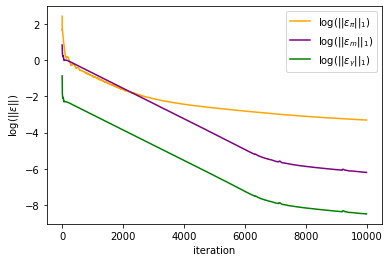

In [53]:
#plt.plot(np.log(mfg_error[:,0])/np.log(10), label = r'$\log(||\varepsilon_u||_1)$', color = 'blue')
plt.plot(np.log(mfg_error[:,1])/np.log(10), label = r'$\log(||\varepsilon_\pi||_1)$', color = 'orange')
plt.plot(np.log(mfg_error[:,2])/np.log(10), label = r'$\log(||\varepsilon_m||_1)$', color = 'purple')
plt.plot(np.log(mfg_error[:,4])/np.log(10), label = r'$\log(||\varepsilon_{\gamma}||_1)$', color = 'green')
#plt.plot(np.log(mfg_error[:,3])/np.log(10), label = r'$\log(||\varepsilon_P||_1)$', color = 'red')
plt.xlabel('iteration')
plt.ylabel(r'$\log(||\varepsilon||)$')
plt.legend()

plt.savefig('ADMM_constraint_mfg_error.png', dpi=500, bbox_inches='tight')

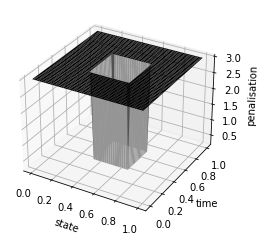

In [54]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, t)
Z = eta

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Greys', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('penalisation')
plt.savefig('eta.png', dpi=500, bbox_inches='tight')

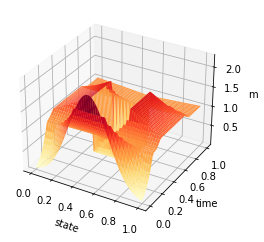

In [55]:
#%matplotlib notebook
Z = m

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='v£iridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('m')
plt.savefig('ADMM_constraint_mfg_m.png', dpi=500, bbox_inches='tight')

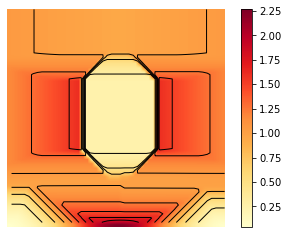

In [56]:
X, Y = np.meshgrid(t, y)
Z = m

minm = np.min(Z)
maxm = np.max(Z)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='YlOrRd')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('ADMM_constraint_mfg_m_contour.png', dpi=500, bbox_inches='tight')

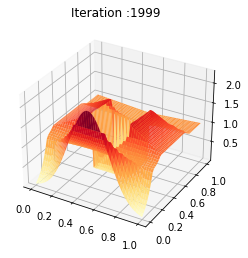

In [57]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="YlOrRd",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('ADMM_constraint_mfg_m_convergence.mp4',writer='ffmpeg',fps=fps)

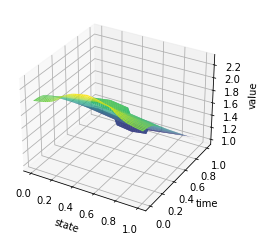

In [58]:
Z = U

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('value')
plt.savefig('ADMM_constraint_mfg_u.png', dpi=500, bbox_inches='tight')

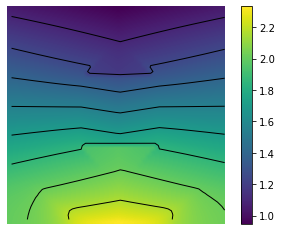

In [59]:
X, Y = np.meshgrid(t, y)
Z = U
minu = np.min(Z)
maxu = np.max(Z)
levels = np.linspace(minu,maxu,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='viridis')

plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('ADMM_constraint_mfg_u_contour.png', dpi=500, bbox_inches='tight')

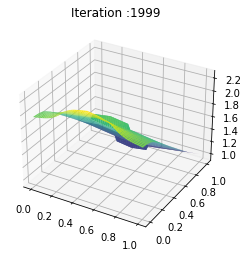

In [60]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_u[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="viridis",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('ADMM_constraint_mfg_u_convergence.mp4',writer='ffmpeg',fps=fps)

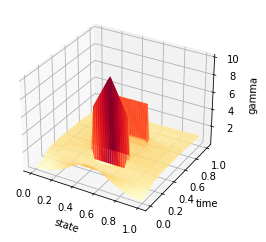

In [61]:
Z = gamma

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('gamma')
plt.savefig('ADMM_constraint_mfg_gamma.png', dpi=500, bbox_inches='tight')

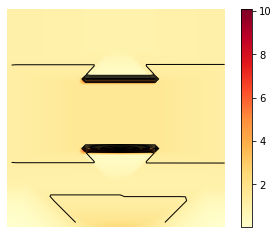

In [62]:
X, Y = np.meshgrid(t, y)
Z = gamma
minu = np.min(Z)
maxu = np.max(Z)
levels = np.linspace(minu,maxu,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='YlOrRd')

plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('ADMM_constraint_mfg_gamma_contour.png', dpi=500, bbox_inches='tight')

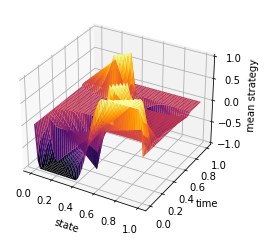

In [63]:
ti = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, ti)
Z = mean_field_strategy(Pi,T,n)

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('mean strategy')

plt.savefig('ADMM_constraint_mfg_mean_strategy.png', dpi=500, bbox_inches='tight')

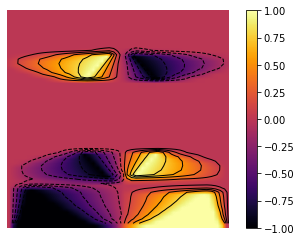

In [64]:
minm = np.min(Z)
maxm = np.max(Z)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='inferno')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('ADMM_constraint_mfg_mean_strategy_contour.png', dpi=500, bbox_inches='tight')

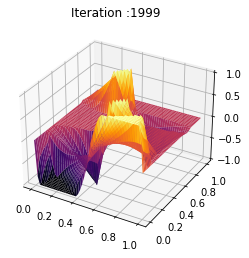

In [65]:
ti = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, ti)
Z = ev_m_s[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="inferno",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('ADMM_constraint_mfg_mean_strategy_convergence.mp4',writer='ffmpeg',fps=fps)

### MFGC

In [67]:
T = 50
n = T

alpha = alpha_cost(T,n)

r = 1/2
q = r

var_alpha = alpha_bar(alpha,T,n)
m_0 = initial_mass(n)

beta = displacement_cost(T,n)
nu = np.zeros((T,n))

D_0 = 1/2
Db = reference_demand(T)*2
Dmin = -2
Dmax = 0


P = np.zeros(T-1) 
u = np.random.rand(T,n)
gamma = np.zeros((T,n))
var_gamma = gamma

m = np.random.rand(T,n)
w = np.zeros((T-1,n,n)) + 1

(a,b) = (m,w)

N = 10000
start = time.time()
error = np.zeros(N)
ev_m_s = np.zeros((N,T-1,n))
ev_m = np.zeros((N,T,n))
ev_u = np.zeros((N,T,n))
mfg_error = np.zeros((N,5))

for i in range(N):
    print(round(i/N*100, 2),"              \r",end = '')
    var_P = P_argmin_L(u,b,w,T,n,r,alpha,var_alpha,Db,D_0,Dmin,Dmax)
    var_u = u_argmin_L(var_P,gamma,a,b,m,w,m_0,alpha,T,n,r)
    (var_a,var_b) = a_b_proj(var_P,var_gamma,var_u,m,w,T,n,r,alpha,beta)
    (var_m,var_w) = m_w_gradient_step(var_P,var_gamma,var_u,var_a,var_b,m,w,q,T,n)
    (P,u,a,b,m,w) = (var_P,var_u,var_a,var_b,var_m,var_w)
    
    (U,Pi) = d_p_mapping(m,w,gamma,P,alpha,beta,T,n,tol = 1e-4)
    mfg_error[i] = np.array(verification(P,U,gamma,m,Pi,w,T,n,beta,nu,m_0,alpha,Db,Dmin,Dmax,eta,mfg=0))
    (ev_m_s[i],ev_m[i],ev_u[i]) = (mean_field_strategy(Pi,T,n),m,U)
    end = time.time()

print("\n execution time :",round(end-start,2), "s")

99.99               
 execution time : 4797.56 s


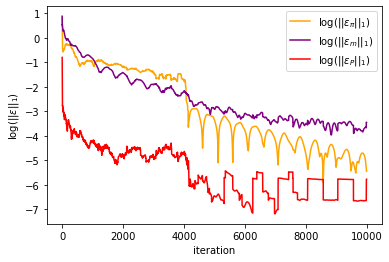

In [68]:
#plt.plot(np.log(mfg_error[:,0])/np.log(10), label = r'$\log(||\varepsilon_u||_1)$', color = 'blue')
plt.plot(np.log(mfg_error[:,1])/np.log(10), label = r'$\log(||\varepsilon_\pi||_1)$', color = 'orange')
plt.plot(np.log(mfg_error[:,2])/np.log(10), label = r'$\log(||\varepsilon_m||_1)$', color = 'purple')
#plt.plot(np.log(mfg_error[:,4])/np.log(10), label = r'$\log(||\varepsilon_{\gamma}||_1)$', color = 'green')
plt.plot(np.log(mfg_error[:,3])/np.log(10), label = r'$\log(||\varepsilon_P||_1)$', color = 'red')
plt.xlabel('iteration')
plt.ylabel(r'$\log(||\varepsilon||_1)$')
plt.legend()

plt.savefig('ADMM_constraint_mfgc_error.png', dpi=500, bbox_inches='tight')

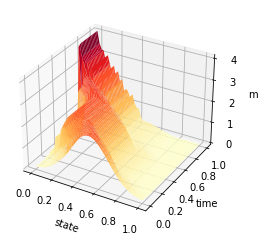

In [69]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(t, y)
Z = m

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='v£iridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('m')
plt.savefig('ADMM_constraint_mfgc_m.png', dpi=500, bbox_inches='tight')

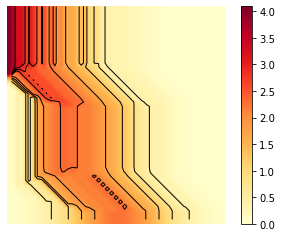

In [70]:
Z = m

minm = np.min(Z)
maxm = np.max(Z)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='YlOrRd')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('ADMM_constraint_mfgc_m_contour.png', dpi=500, bbox_inches='tight')

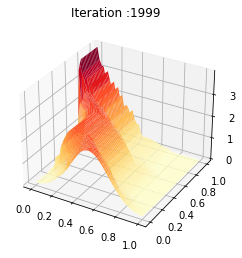

In [71]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="YlOrRd",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('ADMM_constraint_mfgc_m_convergence.mp4',writer='ffmpeg',fps=fps)

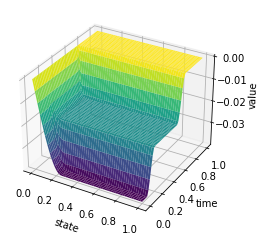

In [72]:
Z = U

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('value')
plt.savefig('ADMM_constraint_mfgc_u.png', dpi=500, bbox_inches='tight')

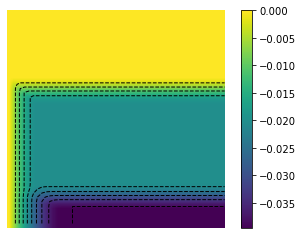

In [73]:
X, Y = np.meshgrid(t, y)
Z = U
minu = np.min(Z)
maxu = np.max(Z)
levels = np.linspace(minu,maxu,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='viridis')

plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('ADMM_constraint_mfgc_u_contour.png', dpi=500, bbox_inches='tight')

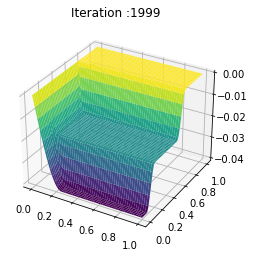

In [74]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_u[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="viridis",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('ADMM_constraint_mfgc_u_convergence.mp4',writer='ffmpeg',fps=fps)

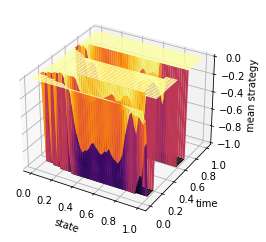

In [75]:
ti = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, ti)
Z = mean_field_strategy(Pi,T,n)

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('mean strategy')

plt.savefig('ADMM_constraint_mfgc_mean_strategy.png', dpi=500, bbox_inches='tight')

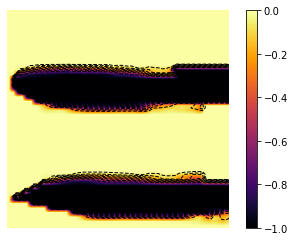

In [76]:
minm = np.min(Z)
maxm = np.max(Z)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='inferno')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('ADMM_constraint_mfgc_mean_strategy_contour.png', dpi=500, bbox_inches='tight')

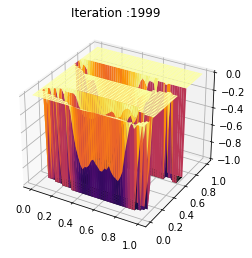

In [77]:
ti = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, ti)
Z = ev_m_s[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="inferno",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('ADMM_constraint_mfgc_mean_strategy_convergence.mp4',writer='ffmpeg',fps=fps)

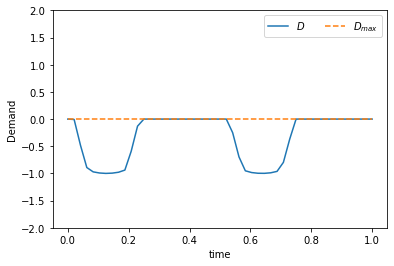

In [78]:
def demand(Db,D_0,alpha,w,T,n):
    dx=1/n
    D_eff = np.zeros(T-1)
    for t in range(T-1):
        D_eff[t] = (np.sum(alpha[t]*w[t])*dx)
    return(D_eff)

plt.plot(np.linspace(0,1,T-1),demand(Db,D_0,alpha,w,T,n), '-',label=r'$D$')
plt.plot(np.linspace(0,1,T-1),np.zeros(T-1) + Dmax,'--', label = r'$D_{max}$')
plt.legend(loc='upper right',
           ncol=2)
plt.xlabel('time')
plt.ylabel('Demand')
plt.ylim([-2, 2])

plt.savefig('Dbar_Dmin.png', dpi=500, bbox_inches='tight')

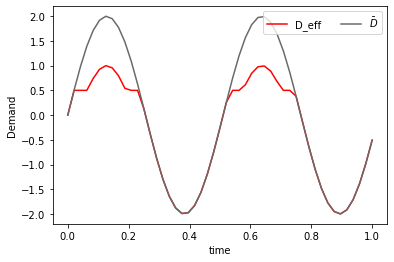

In [79]:
def real_demand(Db,D_0,alpha,w,T,n):
    dx=1/n
    D_eff = np.zeros(T-1)
    for t in range(T-1):
        D_eff[t] = (np.sum(alpha[t]*w[t])*dx + Db[t])
    return(D_eff)

plt.plot(np.linspace(0,1,T-1),real_demand(Db,D_0,alpha,w,T,n), 'r-',label='D_eff')
plt.plot(np.linspace(0,1,T-1),Db, color = 'dimgrey', label = r'$\bar{D}$')
plt.legend(loc='upper right',
           ncol=2)
plt.xlabel('time')
plt.ylabel('Demand')

plt.savefig('ADMM_constraint_mfgc_D.png', dpi=500, bbox_inches='tight')

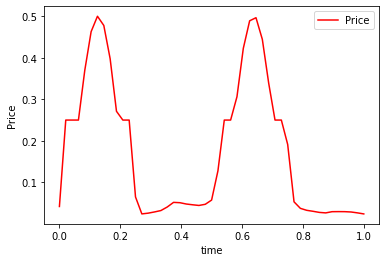

In [80]:
plt.plot(np.linspace(0,1,T-1),P, 'r-',label='Price')
plt.legend(loc='upper right',
           ncol=2)
plt.xlabel('time')
plt.ylabel('Price')

plt.savefig('ADMM_constraint_mfgc_P.png', dpi=500, bbox_inches='tight')

```{bibliography} biblio.bib
:filter: docname in docnames
:style: alpha
```